In [1]:
import sys
import json
import os

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import numpy as np

if r'G:\PythonProjects\WineRecognition2' not in sys.path:
    sys.path.insert(0, r'G:\PythonProjects\WineRecognition2')
from nn.utils import CustomDataset, train, plot_losses, generate_tag_to_ix, get_model_confidence, get_model_mean_confidence
from nn.model import BiLSTM_CRF
from nn.mlflow_utils import log_mlflow_on_train
from data_master import DataGenerator, count_unk_foreach_tag, DataAnalyzer


import neptune
from neptune.types import File

from sklearn_crfsuite import metrics

D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
run = neptune.init_run(
    project="mentalakv/wine-recognition",
    api_token=os.getenv('NEPTUNE_API_KEY'),
)

D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\neptune\common\warnings.py:62: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  warnings.warn(


https://app.neptune.ai/mentalakv/wine-recognition/e/WIN-11


In [3]:
MODEL_NAME = 'BiLSTM_CRF'
RUN_NAME = f'train-H_WS_Brux_MenuSamples+USA+ENG+CAN_Num2Words_'
START_TIME = ''
OUTPUT_DIR = ''
DATASET_PATH = r'G:\PythonProjects\WineRecognition2\data\text\data_and_menu_gen_samples\Halliday_WineSearcher_Bruxelles_MenuGenSamples_v5_BottleSize_fixed.txt'
VOCAB_PATH = r'G:\PythonProjects\WineRecognition2\data\vocabs\Words_Halliday_WineSearcher_Bruxelles_WORD_NUMS.json'
DATAINFO_PATH = r'G:/PythonProjects/WineRecognition2/data_info.json'
DEVICE = 'cuda'
BATCH_SIZE = 2048
EMBEDDING_DIM = 64
HIDDEN_DIM = 64
NUM_EPOCHS = 3
LEARNING_RATE = 0.01
SCHEDULER_FACTOR = 0.1
SCHEDULER_PATIENCE = 10
CASE_SENSITIVE_VOCAB = False
USE_NUM2WORDS = False
WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.2

In [4]:
params = {
    'model_name': MODEL_NAME,
    'run_name': RUN_NAME,
    'dataset_path': DATASET_PATH,
    'vocab_path': VOCAB_PATH,
    'datainfo_path': DATAINFO_PATH,
    'device': DEVICE,
    'batch_size': BATCH_SIZE,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'scheduler_factor': SCHEDULER_FACTOR,
    'scheduler_patience': SCHEDULER_PATIENCE,
    'case_sensitive_vocab': CASE_SENSITIVE_VOCAB,
    'weight_decay': WEIGHT_DECAY,
    'test_size': TEST_SIZE,
    'use_num2words': USE_NUM2WORDS
}
run['parameters'] = params

In [5]:
with open(DATASET_PATH, encoding='utf-8') as file:
    sents = DataGenerator.generate_sents2(file.read().split('\n'))
    sents = sents[:100000]
run['data/dataset'].upload(DATASET_PATH)
len(sents)

100000

In [6]:
train_data, val_data = train_test_split(sents, test_size=TEST_SIZE)
len(train_data), len(val_data)

(80000, 20000)

In [7]:
with open(DATAINFO_PATH) as file:
    tag_to_ix = generate_tag_to_ix(json.load(file)['keys']['all'])

tags_path = os.path.join(OUTPUT_DIR, 'tags.json')
with open(tags_path, 'w', encoding='utf-8') as file:
    json.dump(tag_to_ix, file)
run['data/tags'].upload(tags_path)

tag_to_ix

{'Add_TradeName': 0,
 'Add_Brand': 1,
 'Add_KeyWordTrue': 2,
 'Add_KeyWordFalse': 3,
 'Add_GrapeVarieties': 4,
 'Add_GeoIndication': 5,
 'Add_WineType': 6,
 'Add_BottleSize': 7,
 'Add_Sweetness': 8,
 'Add_WineColor': 9,
 'Add_ClosureType': 10,
 'Add_Certificate': 11,
 'Add_Vintage': 12,
 'Add_Price': 13,
 'Punctuation': 14,
 'Other': 15}

In [8]:
with open(VOCAB_PATH, 'r', encoding='utf-8') as file:
    word_to_ix = json.load(file)
run['data/vocab'].upload(VOCAB_PATH)
len(word_to_ix)

18208

In [9]:
train_dataset = CustomDataset(
    train_data, tag_to_ix, word_to_ix, case_sensitive=CASE_SENSITIVE_VOCAB, convert_nums2words=USE_NUM2WORDS
)
val_dataset = CustomDataset(
    val_data, tag_to_ix, word_to_ix, case_sensitive=CASE_SENSITIVE_VOCAB, convert_nums2words=USE_NUM2WORDS
)

In [10]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
}

In [11]:
vocab_size = len(word_to_ix)
model = BiLSTM_CRF(vocab_size, len(tag_to_ix), EMBEDDING_DIM, HIDDEN_DIM, padding_idx=word_to_ix['PAD']).to(DEVICE)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE)

In [12]:
model, losses = train(
    model,
    optimizer,
    dataloaders,
    DEVICE,
    NUM_EPOCHS,
    OUTPUT_DIR,
    scheduler=scheduler,
    tqdm=tqdm,
    neptune_run=run
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1, train_loss: 13211.339984600361, val_loss: 1609.98447265625
Epoch: 2, train_loss: 904.5972477839543, val_loss: 583.0967346191406
Epoch: 3, train_loss: 385.03253486828925, val_loss: 365.4405792236328


In [13]:
y_val_true = [tags for _, tags in val_dataset.raw_data()]

In [14]:
y_val_pred = []
tags = list(tag_to_ix.keys())
model.eval()
with torch.no_grad():
    for x_batch, y_batch, mask_batch, _ in dataloaders['val']:
        x_batch, mask_batch = x_batch.to(DEVICE), mask_batch.to(DEVICE)
        y_batch_pred = model(x_batch, mask_batch)
        y_val_pred.extend(y_batch_pred)
y_val_pred = [[tags[tag] for tag in sentence] for sentence in y_val_pred]

In [15]:
X_test = [
    torch.tensor(val_dataset.sentence_to_indices(sentence), dtype=torch.int64) for sentence, _ in val_dataset.raw_data()
]

In [16]:
unk_foreach_tag = count_unk_foreach_tag(X_test, y_val_true, list(tag_to_ix), val_dataset.word_to_ix[val_dataset.unk])

unk_foreach_tag_path = os.path.join(OUTPUT_DIR, 'unk_foreach_tag.json')
with open(unk_foreach_tag_path, 'w', encoding='utf-8') as file:
    json.dump(unk_foreach_tag, file)
    
run['data/unk_foreach_tag'].upload(unk_foreach_tag_path)

In [17]:
conf = get_model_mean_confidence(model.to('cpu'), X_test, 'cpu', tqdm=tqdm)

run['val/confidence'] = conf

0it [00:00, ?it/s]

D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\torchcrf\__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ..\aten\src\ATen\native\TensorCompare.cpp:328.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [18]:
test_eval = [list(zip(sentence, tags, y_val_pred[index])) for index, (sentence, tags) in enumerate(val_dataset.raw_data())]

In [19]:
labels=list(tag_to_ix)

run['val/f1'] = metrics.flat_f1_score(y_val_true, y_val_pred, average='weighted', labels=labels)
run['val/precision'] = metrics.flat_precision_score(y_val_true, y_val_pred, average='weighted', labels=labels)
run['val/recall'] = metrics.flat_recall_score(y_val_true, y_val_pred, average='weighted', labels=labels)
run['val/accuracy'] = metrics.flat_accuracy_score(y_val_true, y_val_pred)

flat_class_report_path = os.path.join(OUTPUT_DIR, 'flat-classification-report.txt')
with open(flat_class_report_path, 'w', encoding='utf-8') as file:
    file.write(metrics.flat_classification_report(y_val_true, y_val_pred, labels=labels, digits=3))
run['data/flat_classification_report'].upload(flat_class_report_path)

D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sk

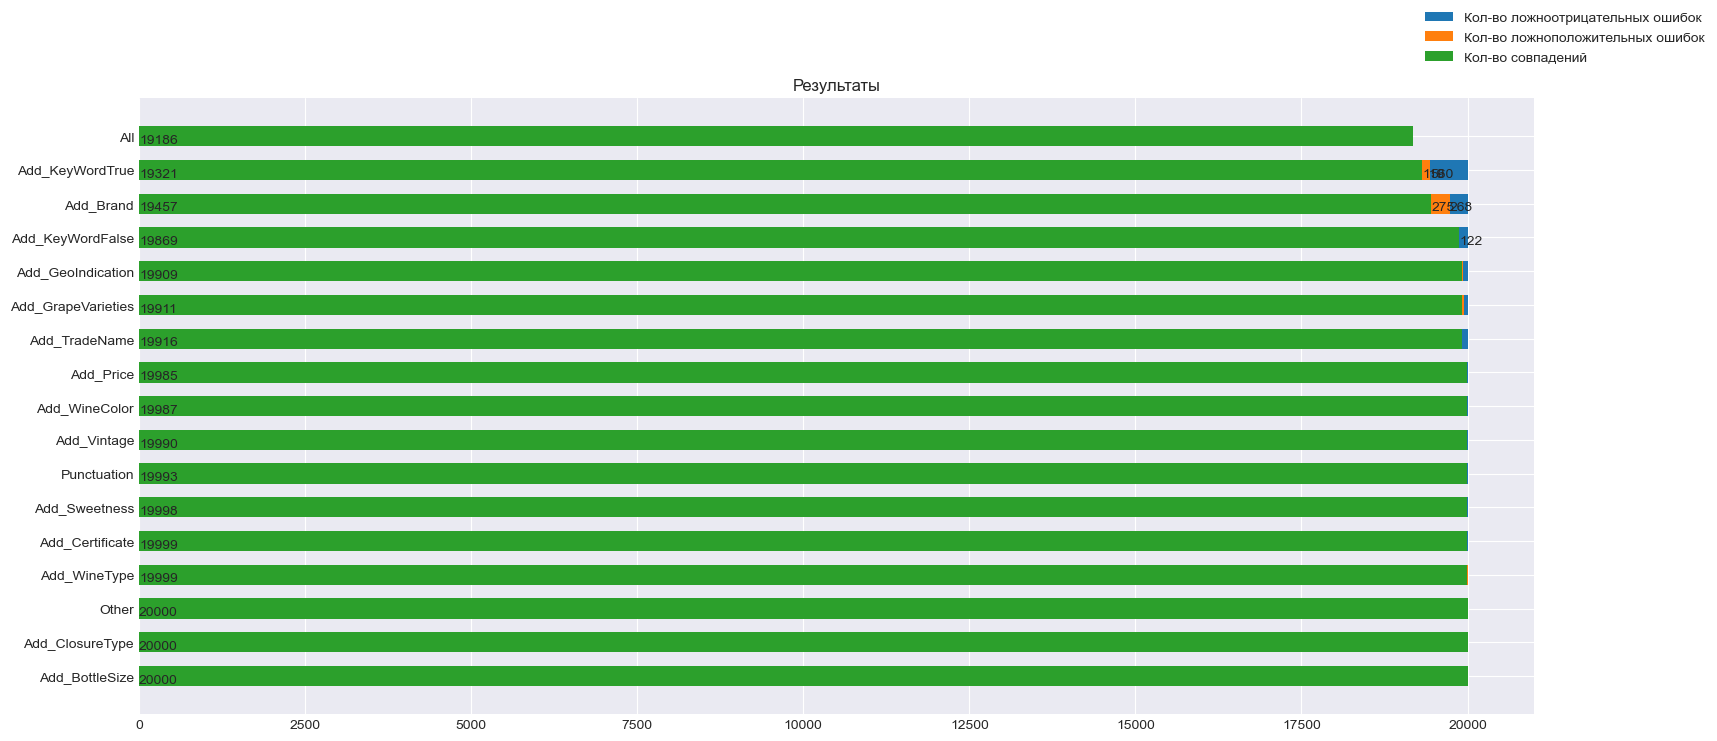

In [21]:
colored_table_path = os.path.join(OUTPUT_DIR, 'colored-table.xlsx')
diagram_path = os.path.join(OUTPUT_DIR, 'diagram.png')

DataAnalyzer.analyze(
        test_eval,
        keys=labels,
        table_save_path=colored_table_path,
        diagram_save_path=diagram_path)

run['data/colored_table'].upload(colored_table_path)
run['data/diagram'].upload(diagram_path)

In [22]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/mentalakv/wine-recognition/e/WIN-11/metadata
